In [5]:
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

import antea.reco.reco_functions   as rf
import antea.elec.tof_functions    as tf
import antea.reco.mctrue_functions as mcf
import antea.io  .mc_io            as mcio

from antea.utils.map_functions import load_map
from invisible_cities.core     import system_of_units as units

In [8]:
filespath     = '/Users/carmenromoluque/nexus_petit_analysis/tof_setup/PetBox_analysis/data_h5/'
filename      = filespath + 'PetBox_asymmetric_tile5centered_HamamatsuVUV.046.pet.h5'

sns_response  = mcio.load_mcsns_response   (filename)
sns_positions = mcio.load_sns_positions    (filename)
mcparticles   = mcio.load_mcparticles      (filename)
mchits        = mcio.load_mchits           (filename)
tof_response  = mcio.load_mcTOFsns_response(filename)

DataSiPM     = sns_positions.rename(columns={"sensor_id": "SensorID","x": "X", "y": "Y", "z": "Z"})
DataSiPM_idx = DataSiPM.set_index('SensorID')

tof_bin_size  = mcio.read_sensor_bin_width_from_conf(filename, tof=True)

In [9]:
thr_charge1   = 1400 #pes
thr_charge2   =  200 #pes

area0       = [ 44,  45,  54,  55]
area0_tile5 = [122, 123, 132, 133]

zpos_file  = '/Users/carmenromoluque/Analysis/pet_box/tile5_centered/z_var_x_table_pet_box_HamamatsuVUV_det_plane_coinc_plane_cent.h5'
zpos_file2 = '/Users/carmenromoluque/Analysis/pet_box/tile5_centered/z_var_x_table_pet_box_HamamatsuVUV_coinc_plane_cent.h5'

Zpos1 = load_map(zpos_file, group="Zpos",
                            node=f"f2pes200bins",
                            x_name='Var_x',
                            y_name='Zpos',
                            u_name='ZposUncertainty')
Zpos2 = load_map(zpos_file2, group="Zpos",
                             node=f"f2pes200bins",
                             x_name='Var_x',
                             y_name='Zpos',
                             u_name='ZposUncertainty')

sigma_sipm = 80 #ps
sigma_elec = 30 #ps

timestamp_thr = [0, 0.25, 0.50, 0.75]
### parameters for single photoelectron convolution in SiPM response
tau_sipm       = [100, 15000]
time_window    = 5000
time           = np.arange(0, 5000)
spe_resp, norm = tf.apply_spe_dist(time, tau_sipm)
th     = 2

In [12]:
def info_from_the_tiles(DataSiPM_idx, evt_sns):
    sipms       = DataSiPM_idx.loc[evt_sns.sensor_id]
    sns_ids     = sipms.index.astype('int64').values
    sns_pos     = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    sns_charges = evt_sns.charge.values
    sel = sipms.Z.values<0
    return (sns_ids[ sel], sns_pos[ sel], sns_charges[ sel], #Plane with 4 tiles
            sns_ids[~sel], sns_pos[~sel], sns_charges[~sel]) #Plane with 1 tile


def select_phot_pet_box(evt_parts,
                        evt_hits,
                        he_gamma=False):
    """
    Select only the events where one or two photoelectric events occur, and nothing else.
    """
    sel_volume   = (evt_parts.initial_volume == 'ACTIVE') & (evt_parts.final_volume == 'ACTIVE')
    sel_name     =  evt_parts.particle_name == 'e-'
    sel_vol_name = evt_parts[sel_volume & sel_name]
    ids          = sel_vol_name.particle_id.values

    sel_hits   = mcf.find_hits_of_given_particles(ids, evt_hits)
    energies   = sel_hits.groupby(['particle_id'])[['energy']].sum()
    energies   = energies.reset_index()
    if he_gamma:
        energy_sel = energies[rf.greater_or_equal(energies.energy, 1.23998, allowed_error=1.e-5)]
        primaries = evt_parts[(evt_parts.primary == True) & (evt_parts.kin_energy == 1.274537)]
    else:
        energy_sel = energies[rf.greater_or_equal(energies.energy, 0.476443, allowed_error=1.e-6)]
        primaries = evt_parts[(evt_parts.primary == True) & (evt_parts.kin_energy == 0.510999)]

    sel_vol_name_e = sel_vol_name  [sel_vol_name  .particle_id.isin(energy_sel.particle_id)]
    sel_all        = sel_vol_name_e[sel_vol_name_e.mother_id  .isin(primaries .particle_id.values)]

    if len(sel_all) == 0:
        return (False, np.array([]))

    ### Once the event has passed the selection, let's calculate the true position(s)
    ids      = sel_all.particle_id.values
    sel_hits = mcf.find_hits_of_given_particles(ids, evt_hits)

    sel_hits = sel_hits.groupby(['particle_id'])
    true_pos = []
    for _, df in sel_hits:
        hit_positions = np.array([df.x.values, df.y.values, df.z.values]).transpose()
        true_pos.append(np.average(hit_positions, axis=0, weights=df.energy))

    return (True, np.array(true_pos))

### Event 280

In [53]:
events = mcparticles.event_id.unique()
for evt in events[280:281]:
    print(evt)
    count1 = 0
    count2 = 0
    evt_sns   = sns_response[sns_response.event_id == evt]
    evt_parts = mcparticles [mcparticles .event_id == evt]
    evt_hits  = mchits      [mchits      .event_id == evt]
    evt_tof   = tof_response[tof_response.event_id == evt]
    evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=th)
    if len(evt_sns) == 0:
        continue
    ids_over_thr = evt_sns.sensor_id.astype('int64').values
    evt_tof      = evt_tof[evt_tof.sensor_id.isin(-ids_over_thr)]
    ## True info
    phot, true_pos_phot   = select_phot_pet_box(evt_parts, evt_hits, he_gamma=False)
    he_gamma, true_pos_he = select_phot_pet_box(evt_parts, evt_hits, he_gamma=True)
    sel_phot0    = np.array([pos[2] for pos in true_pos_phot])
    sel_neg_phot = sel_phot0[sel_phot0<0]
    sel_pos_phot = sel_phot0[sel_phot0>0]
    sel_he0    = np.array([pos[2] for pos in true_pos_he])
    sel_neg_he = sel_he0[sel_he0<0]
    sel_pos_he = sel_he0[sel_he0>0]
    if phot and len(sel_neg_phot)>0:
        if len(sel_neg_he)>0:
            continue
        ids1, pos1, qs1, _, _, _ = info_from_the_tiles(DataSiPM_idx, evt_sns)
        if len(qs1)==0:
            continue
        max_charge_s_id       = ids1[np.argmax(qs1)]
        if max_charge_s_id in area0:
            true_pos_neg_evt = true_pos_phot[sel_phot0<0][0]
            pos_xs1 = np.array(pos1.T[0])
            mean_x1 = np.average(pos_xs1, weights=qs1)
            var_xs1 = np.average((pos_xs1 - mean_x1)**2, weights=qs1)
            pos_ys1 = np.array(pos1.T[1])
            mean_y1 = np.average(pos_ys1, weights=qs1)
            z_pos1 = Zpos1(var_xs1).value
            if sum(qs1)>thr_charge1:
                count1 = 1
    if phot and len(sel_pos_phot)>0:
        if len(sel_pos_he)>0:
            continue
        _, _, _, ids2, pos2, qs2 = info_from_the_tiles(DataSiPM_idx, evt_sns)
        if len(qs2)==0:
            continue
        max_charge_s_id_tile5 = ids2[np.argmax(qs2)]
        if max_charge_s_id_tile5 in area0_tile5:
            true_pos_pos_evt = true_pos_phot[sel_phot0>0][0]
            pos_xs2 = np.array(pos2.T[0])
            mean_x2 = np.average(pos_xs2, weights=qs2)
            var_xs2 = np.average((pos_xs2 - mean_x2)**2, weights=qs2)
            pos_ys2 = np.array(pos2.T[1])
            mean_y2 = np.average(pos_ys2, weights=qs2)
            z_pos2 = Zpos2(var_xs2).value
            if sum(qs2)>thr_charge2:
                count2 = 1
            #if sum(qs1)>thr_charge1 and sum(qs2)>thr_charge2:
            if count1 and count2: ## Coincidences
                ## produce a TOF dataframe with convolved time response
                times = evt_tof.time_bin.values * tof_bin_size / units.ps
                evt_tof['time'] = np.round(np.random.normal(times, sigma_sipm)).astype(int)
                tof_sns = evt_tof.sensor_id.unique()
                evt_tof_exp_dist = []
                for s_id in tof_sns:
                    tdc_conv    = tf.tdc_convolution(evt_tof, spe_resp, s_id, time_window)
                    tdc_conv_df = tf.translate_charge_conv_to_wf_df(evt, s_id, tdc_conv)
                    evt_tof_exp_dist.append(tdc_conv_df)
                evt_tof_exp_dist = pd.concat(evt_tof_exp_dist)
                ## Calculate different thresholds in charge
                for k, th in enumerate(timestamp_thr[:1]):
                    evt_tof_exp_dist = evt_tof_exp_dist[evt_tof_exp_dist.charge > th/norm]
                    min_id1, min_id2, min_t1, min_t2 = rf.find_coincidence_timestamps(evt_tof_exp_dist, ids1, ids2, n_pe=1)
                    print(min_id1, min_id2, min_t1, min_t2)

460280
[26] [133] 258 436


In [47]:
true_pos_phot

array([[  5.639673 ,   2.1409228, -44.235054 ],
       [ -4.969873 ,  -1.9243046,  38.579777 ]], dtype=float32)

In [66]:
pos1_xs = np.array(pos1.T[0])
pos1_ys = np.array(pos1.T[1])
pos1_zs = np.array(pos1.T[2])

pos2_xs = np.array(pos2.T[0])
pos2_ys = np.array(pos2.T[1])
pos2_zs = np.array(pos2.T[2])

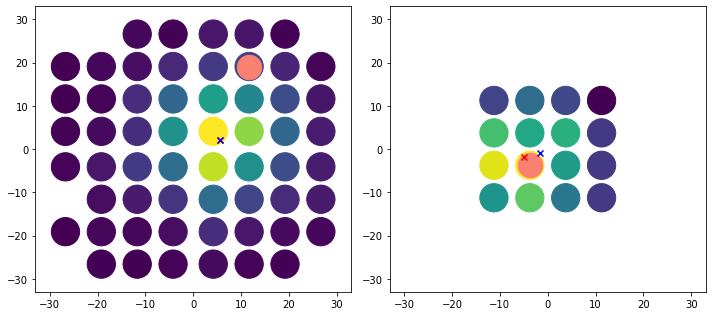

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4.5))
plt.rcParams["figure.figsize"] = (6,5)
ax1.scatter(pos1_xs, pos1_ys, c=qs1, s=800)
ax2.scatter(pos2_xs, pos2_ys, c=qs2, s=800)

ax1.scatter(get_sipm_pos(min_id1)[0][0], get_sipm_pos(min_id1)[0][1], s=600, color='salmon', label='first pes')
ax2.scatter(get_sipm_pos(min_id2)[0][0], get_sipm_pos(min_id2)[0][1], s=600, color='salmon', label='first pes')

ax1.scatter(true_pos_phot[0][0], true_pos_phot[0][1], marker='x', color='r', label='True pos')
ax2.scatter(true_pos_phot[1][0], true_pos_phot[1][1], marker='x', color='r', label='True pos')
ax1.scatter(mean_x1, mean_y1, marker='x', color='b', label='Reco pos')
ax2.scatter(mean_x2, mean_y2, marker='x', color='b', label='Reco pos')

get_sipm_pos(min_id1)[0]
ax1.set_xlim(-33, 33)
ax2.set_xlim(-33, 33)
ax1.set_ylim(-33, 33)
ax2.set_ylim(-33, 33)
plt.tight_layout()
plt.show()

In [72]:
get_sipm_pos(min_id1)[0]

array([ 11.7  ,  19.1  , -55.405], dtype=float32)

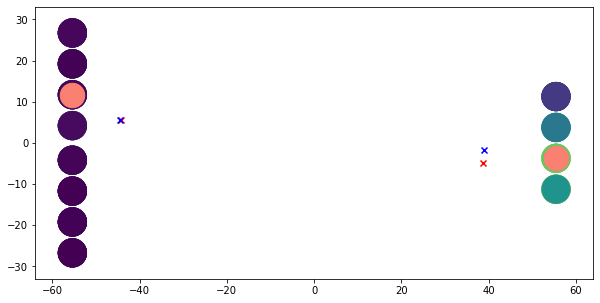

In [78]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(pos1_zs, pos1_xs, c=qs1, s=800)
plt.scatter(pos2_zs, pos2_xs, c=qs2, s=800)
for true_pos in true_pos_phot:
    plt.scatter(true_pos[2], true_pos[0], marker='x', color='r', label='True pos')

plt.scatter(get_sipm_pos(min_id1)[0][2], get_sipm_pos(min_id1)[0][0], s=600, color='salmon', label='first pes')
plt.scatter(get_sipm_pos(min_id2)[0][2], get_sipm_pos(min_id2)[0][0], s=600, color='salmon', label='first pes')

plt.scatter(z_pos1, mean_x1, marker='x', color='b', label='Reco pos')
plt.scatter(z_pos2, mean_x2, marker='x', color='b', label='Reco pos')

plt.ylim(-33, 33)
plt.show()

In [54]:
min_id1

array([26], dtype=int32)

In [70]:
def get_sipm_pos(id_values):
    xvals = [sns_positions[sns_positions.sensor_id == id_values[s_id]].x.values[0] 
             for s_id in range(len(id_values))]
    yvals = [sns_positions[sns_positions.sensor_id == id_values[s_id]].y.values[0] 
             for s_id in range(len(id_values))]
    zvals = [sns_positions[sns_positions.sensor_id == id_values[s_id]].z.values[0] 
             for s_id in range(len(id_values))]
    return np.array([xvals, yvals, zvals]).T

In [63]:
ave_speed_in_LXe  = 0.210 # mm/ps
speed_in_vacuum   = 0.299792458 # mm/ps
peak_speed_in_LXe = speed_in_vacuum/1.69

cart1 = np.array([mean_x1, mean_y1, z_pos1]).T
cart2 = np.array([mean_x2, mean_y2, z_pos2]).T

### Distance between interaction point and center of the geometry
dg1 = np.linalg.norm(cart1)
dg2 = np.linalg.norm(cart2)

first_sipm_pos1 = get_sipm_pos(sns_positions, min_id1)
first_sipm_pos2 = get_sipm_pos(sns_positions, min_id2)

dp1 = np.linalg.norm(np.subtract(cart1, first_sipm_pos1), axis=1)
dp2 = np.linalg.norm(np.subtract(cart2, first_sipm_pos2), axis=1)

delta_t  = min_t2 - min_t1 + (dp1 - dp2)/ave_speed_in_LXe  + (dg1 - dg2)/speed_in_vacuum
delta_t2 = min_t2 - min_t1 + (dp1 - dp2)/peak_speed_in_LXe + (dg1 - dg2)/speed_in_vacuum

In [64]:
delta_t

array([217.74779979])